In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import os
from scipy import signal
from scipy.stats import ttest_rel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_auc_score, f1_score)
from mne.decoding import CSP
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("All imports complete")

All imports complete


In [4]:
# =============================================================================
# CONFIGURATION
# =============================================================================
DATA_DIR = '/home/shayankh1996/Desktop/EEG_CWT/Data/Subjects'
SUBJECT_LIST = ['subject_3', 'subject_4', 'subject_5', 'subject_14']

# Channel configuration
EEG_CHANNELS = ['FP1', 'FP2', 'F3', 'FZ', 'F4', 'T7', 'C3', 'CZ',
                'C4', 'T8', 'P3', 'PZ', 'P4', 'PO7', 'PO8', 'OZ']
ROI_CHANNELS = ['F3', 'FZ', 'F4', 'C3', 'CZ', 'C4', 'P3', 'PZ', 'P4']
roi_indices = [EEG_CHANNELS.index(ch) for ch in ROI_CHANNELS]

# Sampling & timing
FS = 256
WIN_SIZE = 1536  # 6 seconds

# Time phases (in samples)
BASELINE_SLICE = slice(0, 128)      # First 0.5s for baseline
PLANNING_SLICE = slice(128, 768)    # 0.5s to 3s
MOVEMENT_SLICE = slice(768, 1536)   # 3s to 6s

# Artifact rejection - SET TO None TO DISABLE
# Your g.USBamp data may have high amplitudes, start with None
ARTIFACT_THRESHOLD_UV = None  # Try 500 if you want to enable

# ADC conversion
SENSITIVITY_MV = 250
ADC_BITS = 24
CONVERSION_FACTOR = (2 * SENSITIVITY_MV * 1000) / (2**ADC_BITS)

print(f"Artifact threshold: {ARTIFACT_THRESHOLD_UV}")
print(f"Baseline period: 0-0.5s")
print(f"Planning phase: 0.5-3s")
print(f"Movement phase: 3-6s")

Artifact threshold: None
Baseline period: 0-0.5s
Planning phase: 0.5-3s
Movement phase: 3-6s


In [5]:
# =============================================================================
# DATA LOADING (FIXED - with optional artifact rejection)
# =============================================================================
def load_subject_data(subject_folder, artifact_threshold=None):
    """
    Loads and preprocesses subject data with OPTIONAL artifact rejection.
    
    Parameters:
    -----------
    artifact_threshold : float or None
        Set to None to disable artifact rejection
    """
    all_eeg = []
    all_labels = []
    
    if not os.path.exists(subject_folder):
        return None, None, 0
        
    files = sorted([f for f in os.listdir(subject_folder) if f.endswith('.csv')])
    
    for file in files:
        df = pd.read_csv(os.path.join(subject_folder, file))
        
        # Cleanup
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)
        if 'buzzer' in df.columns:
            df = df.drop('buzzer', axis=1)
        
        # Filter Bottle (0) vs Empty (1)
        if 'events' not in df.columns:
            continue
        df = df[df['events'].isin([0, 1])]
        
        # Epoching
        for start in range(0, len(df), WIN_SIZE):
            end = start + WIN_SIZE
            if end <= len(df):
                trial = df[EEG_CHANNELS].iloc[start:end].values
                label = df['events'].iloc[start]
                all_eeg.append(trial)
                all_labels.append(label)
                
    if len(all_eeg) == 0:
        return None, None, 0
        
    # Convert to array and transpose
    data = np.array(all_eeg).transpose(0, 2, 1)  # (trials, channels, time)
    labels = np.array(all_labels)
    
    # Unit conversion
    data = data * CONVERSION_FACTOR
    
    # Artifact rejection (OPTIONAL with safety check)
    n_rejected = 0
    if artifact_threshold is not None:
        n_original = len(data)
        max_amplitudes = np.max(np.abs(data), axis=(1, 2))
        valid_mask = max_amplitudes < artifact_threshold
        
        # Safety: don't reject everything!
        if np.sum(valid_mask) < 10:
            print(f"    WARNING: Threshold too strict! Would keep only {np.sum(valid_mask)}/{n_original} epochs")
            print(f"    Amplitude range: {max_amplitudes.min():.1f} - {max_amplitudes.max():.1f} uV")
            print(f"    Disabling artifact rejection.")
        else:
            data = data[valid_mask]
            labels = labels[valid_mask]
            n_rejected = n_original - len(data)
    
    # Baseline correction
    baseline = data[:, :, BASELINE_SLICE].mean(axis=2, keepdims=True)
    data = data - baseline
    
    return data, labels, n_rejected

In [6]:
# =============================================================================
# FILTER BANK FUNCTION
# =============================================================================
def apply_filter_bank(eeg_data, fs=256):
    """Applies 9-band filter bank with CAR."""
    bands = [
        (4, 8), (8, 12), (12, 16), (16, 20),
        (20, 24), (24, 28), (28, 32), (32, 36), (36, 40)
    ]
    
    bank_data = {}
    eeg_car = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)
    
    for (low, high) in bands:
        b, a = signal.butter(4, [low/(fs/2), high/(fs/2)], btype='band')
        filtered = signal.filtfilt(b, a, eeg_car, axis=2)
        bank_data[f'{low}-{high}Hz'] = filtered
        
    return bank_data

In [7]:
# =============================================================================
# FBCSP FEATURE EXTRACTION
# =============================================================================
def extract_fbcsp_features(X_train, X_test, y_train, n_csp_components=2, k_best=8):
    """Extracts FBCSP features with SelectKBest."""
    train_bank = apply_filter_bank(X_train)
    test_bank = apply_filter_bank(X_test)
    
    train_feats_list = []
    test_feats_list = []
    bands = sorted(train_bank.keys(), key=lambda x: int(x.split('-')[0]))
    
    for band in bands:
        csp = CSP(n_components=n_csp_components, reg='ledoit_wolf', 
                  log=True, norm_trace=False)
        f_train = csp.fit_transform(train_bank[band], y_train)
        f_test = csp.transform(test_bank[band])
        train_feats_list.append(f_train)
        test_feats_list.append(f_test)
    
    X_train_full = np.concatenate(train_feats_list, axis=1)
    X_test_full = np.concatenate(test_feats_list, axis=1)
    
    selector = SelectKBest(mutual_info_classif, k=k_best)
    X_train_sel = selector.fit_transform(X_train_full, y_train)
    X_test_sel = selector.transform(X_test_full)
    
    selected_indices = selector.get_support(indices=True)
    selected_bands = [idx // n_csp_components for idx in selected_indices]
    
    return X_train_sel, X_test_sel, selected_bands

In [8]:
def evaluate_subject(data, labels, time_phase='movement'):
    """
    Comprehensive FBCSP evaluation with full metrics.
    
    Parameters:
    -----------
    data : ndarray (n_trials, n_channels, n_times)
    labels : ndarray (n_trials,)
    time_phase : str, one of 'movement', 'planning', 'combined'
    
    Returns:
    --------
    dict with accuracy, f1_score, roc_auc, confusion_matrix, fold_scores, band_usage
    """
    
    # Time phase selection
    if time_phase == 'movement':
        X = data[:, roi_indices, MOVEMENT_SLICE]
    elif time_phase == 'planning':
        X = data[:, roi_indices, PLANNING_SLICE]
    elif time_phase == 'combined':
        X_plan = data[:, roi_indices, PLANNING_SLICE]
        X_move = data[:, roi_indices, MOVEMENT_SLICE]
        X = np.concatenate([X_plan, X_move], axis=2)
    else:
        raise ValueError(f"Unknown time_phase: {time_phase}")
    
    y = labels
    
    # Check minimum samples
    if len(y) < 10:
        print(f"    ERROR: Only {len(y)} samples, need at least 10")
        return None
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Storage for metrics
    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    fold_scores = []
    band_usage = np.zeros(9)  # Track which bands are selected
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # FBCSP feature extraction
        X_train_feat, X_test_feat, selected_bands = extract_fbcsp_features(
            X_train, X_test, y_train
        )
        
        # Track band usage
        for b in selected_bands:
            band_usage[b] += 1
        
        # Classification
        clf = LinearDiscriminantAnalysis()
        clf.fit(X_train_feat, y_train)
        
        y_pred = clf.predict(X_test_feat)
        y_proba = clf.predict_proba(X_test_feat)[:, 1]
        
        # Store predictions
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)
        fold_scores.append(accuracy_score(y_test, y_pred))
    
    # Compute all metrics
    results = {
        'accuracy': np.mean(fold_scores),
        'accuracy_std': np.std(fold_scores),
        'f1_score': f1_score(all_y_true, all_y_pred),
        'roc_auc': roc_auc_score(all_y_true, all_y_proba),
        'confusion_matrix': confusion_matrix(all_y_true, all_y_pred),
        'fold_scores': fold_scores,
        'band_usage': band_usage / band_usage.sum() if band_usage.sum() > 0 else band_usage,
        'y_true': np.array(all_y_true),
        'y_pred': np.array(all_y_pred),
        'y_proba': np.array(all_y_proba)
    }
    
    return results

In [9]:
# =============================================================================
# RUN COMPREHENSIVE EVALUATION
# =============================================================================
print("="*70)
print("COMPREHENSIVE FBCSP EVALUATION")
print("="*70)

all_results = {}

for subj in SUBJECT_LIST:
    print(f"\n{'='*70}")
    print(f"Subject: {subj}")
    print(f"{'='*70}")
    
    folder_path = os.path.join(DATA_DIR, subj)
    data, labels, n_rejected = load_subject_data(folder_path, ARTIFACT_THRESHOLD_UV)
    
    if data is None or len(labels) == 0:
        print(f"  Skipped (no data)")
        continue
    
    print(f"  Trials: {len(labels)} (rejected: {n_rejected})")
    print(f"  Class balance: {np.sum(labels==0)} Bottle / {np.sum(labels==1)} Empty")
    
    subj_results = {}
    
    for phase in ['movement', 'planning', 'combined']:
        print(f"\n  [{phase.upper()} PHASE]")
        results = evaluate_subject(data, labels, time_phase=phase)
        
        if results is None:
            continue
            
        subj_results[phase] = results
        
        # Print comprehensive metrics
        print(f"    Accuracy:  {results['accuracy']*100:.1f}% ± {results['accuracy_std']*100:.1f}%")
        print(f"    F1-Score:  {results['f1_score']:.3f}")
        print(f"    ROC-AUC:   {results['roc_auc']:.3f}")
        print(f"    Confusion Matrix:")
        cm = results['confusion_matrix']
        print(f"               Pred:0  Pred:1")
        print(f"      True:0   [{cm[0,0]:4d}   {cm[0,1]:4d}]")
        print(f"      True:1   [{cm[1,0]:4d}   {cm[1,1]:4d}]")
    
    if subj_results:
        all_results[subj] = subj_results

print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)

COMPREHENSIVE FBCSP EVALUATION

Subject: subject_3
  Trials: 150 (rejected: 0)
  Class balance: 75 Bottle / 75 Empty

  [MOVEMENT PHASE]
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 9 dim * 1.1e+15  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.92 (2.2e-16 eps * 9 dim * 4.6e+14  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.53 (2.2e-16 eps * 9 dim * 2.6e+14  max singular value)
    Estimated rank (data): 9
    data: rank 9 c

In [10]:
# =============================================================================
# SUMMARY TABLES
# =============================================================================

# Table 1: Accuracy by Phase
print("\n" + "="*70)
print("TABLE 1: ACCURACY BY TEMPORAL PHASE")
print("="*70)
subjects = list(all_results.keys())
phases = ['movement', 'planning', 'combined']

print(f"\n{'Subject':<12} | {'Movement':<14} | {'Planning':<14} | {'Combined':<14}")
print("-"*60)

for subj in subjects:
    row = f"{subj:<12} |"
    for phase in phases:
        if phase in all_results[subj]:
            acc = all_results[subj][phase]['accuracy']
            std = all_results[subj][phase]['accuracy_std']
            row += f" {acc*100:5.1f}% ± {std*100:4.1f}% |"
        else:
            row += f" {'N/A':^12} |"
    print(row)

print("-"*60)
# Grand averages
for phase in phases:
    phase_accs = [all_results[s][phase]['accuracy'] for s in subjects if phase in all_results[s]]
    if phase_accs:
        print(f"Grand Avg ({phase}): {np.mean(phase_accs)*100:.1f}%")


# Table 2: Full Metrics (Movement Phase)
print("\n" + "="*70)
print("TABLE 2: COMPREHENSIVE METRICS (MOVEMENT PHASE)")
print("="*70)

print(f"\n{'Subject':<12} | {'Accuracy':<14} | {'F1-Score':<10} | {'ROC-AUC':<10}")
print("-"*55)

f1_scores = []
auc_scores = []

for subj in subjects:
    if 'movement' in all_results[subj]:
        r = all_results[subj]['movement']
        print(f"{subj:<12} | {r['accuracy']*100:5.1f}% ± {r['accuracy_std']*100:4.1f}% | {r['f1_score']:.3f}      | {r['roc_auc']:.3f}")
        f1_scores.append(r['f1_score'])
        auc_scores.append(r['roc_auc'])

print("-"*55)
avg_acc = np.mean([all_results[s]['movement']['accuracy'] for s in subjects])
print(f"{'Average':<12} | {avg_acc*100:5.1f}%          | {np.mean(f1_scores):.3f}      | {np.mean(auc_scores):.3f}")


TABLE 1: ACCURACY BY TEMPORAL PHASE

Subject      | Movement       | Planning       | Combined      
------------------------------------------------------------
subject_3    |  99.3% ±  1.3% |  57.3% ± 11.6% |  98.7% ±  2.7% |
subject_4    |  92.7% ±  1.3% |  61.3% ± 13.9% |  85.3% ±  3.4% |
subject_5    |  65.3% ±  7.5% |  48.0% ±  6.2% |  58.7% ±  1.6% |
subject_14   |  81.3% ±  3.4% |  50.0% ±  7.0% |  68.7% ± 10.0% |
------------------------------------------------------------
Grand Avg (movement): 84.7%
Grand Avg (planning): 54.2%
Grand Avg (combined): 77.8%

TABLE 2: COMPREHENSIVE METRICS (MOVEMENT PHASE)

Subject      | Accuracy       | F1-Score   | ROC-AUC   
-------------------------------------------------------
subject_3    |  99.3% ±  1.3% | 0.993      | 1.000
subject_4    |  92.7% ±  1.3% | 0.925      | 0.962
subject_5    |  65.3% ±  7.5% | 0.634      | 0.714
subject_14   |  81.3% ±  3.4% | 0.811      | 0.872
-------------------------------------------------------
Averag

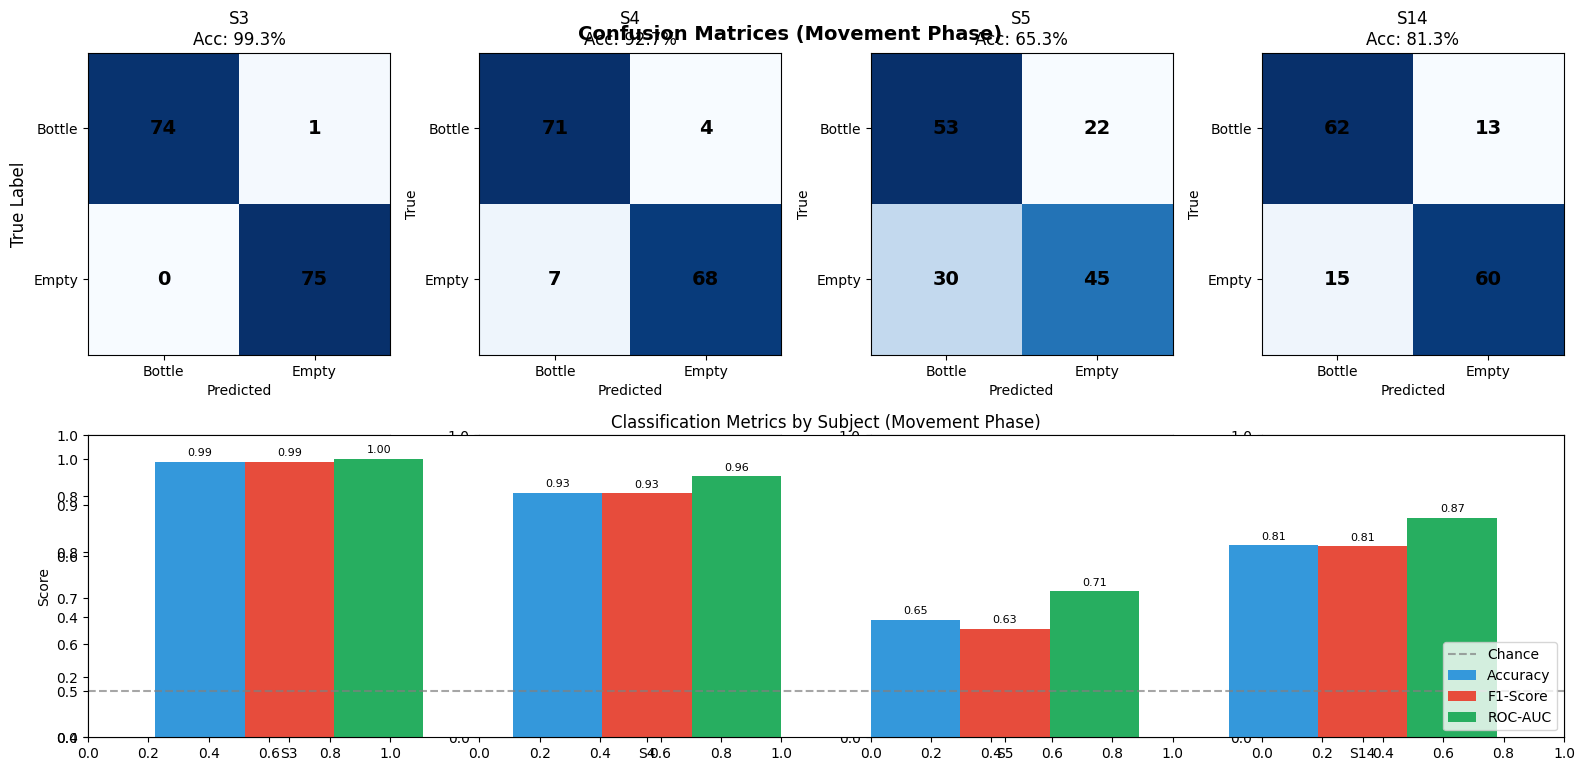


Figure saved: fbcsp_evaluation_metrics.png


In [11]:
# =============================================================================
# VISUALIZATION
# =============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

subjects = list(all_results.keys())
phases = ['movement', 'planning', 'combined']
colors = ['#3498db', '#e74c3c', '#27ae60']

# Row 1: Confusion Matrices (Movement Phase)
for i, subj in enumerate(subjects):
    ax = axes[0, i]
    if 'movement' in all_results[subj]:
        cm = all_results[subj]['movement']['confusion_matrix']
        im = ax.imshow(cm, cmap='Blues')
        
        # Add text annotations
        for row in range(2):
            for col in range(2):
                ax.text(col, row, str(cm[row, col]), 
                       ha='center', va='center', fontsize=14, fontweight='bold')
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Bottle', 'Empty'])
        ax.set_yticklabels(['Bottle', 'Empty'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        
        acc = all_results[subj]['movement']['accuracy']
        ax.set_title(f"{subj.replace('subject_', 'S')}\nAcc: {acc*100:.1f}%")

axes[0, 0].set_ylabel('True Label', fontsize=12)
fig.text(0.5, 0.95, 'Confusion Matrices (Movement Phase)', ha='center', fontsize=14, fontweight='bold')

# Row 2: Metrics Comparison Bar Chart
ax2 = plt.subplot(2, 1, 2)

x = np.arange(len(subjects))
width = 0.25

accs = [all_results[s]['movement']['accuracy'] for s in subjects]
f1s = [all_results[s]['movement']['f1_score'] for s in subjects]
aucs = [all_results[s]['movement']['roc_auc'] for s in subjects]

bars1 = ax2.bar(x - width, accs, width, label='Accuracy', color='#3498db')
bars2 = ax2.bar(x, f1s, width, label='F1-Score', color='#e74c3c')
bars3 = ax2.bar(x + width, aucs, width, label='ROC-AUC', color='#27ae60')

ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.7, label='Chance')
ax2.set_ylabel('Score')
ax2.set_title('Classification Metrics by Subject (Movement Phase)')
ax2.set_xticks(x)
ax2.set_xticklabels([s.replace('subject_', 'S') for s in subjects])
ax2.legend(loc='lower right')
ax2.set_ylim(0.4, 1.05)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('fbcsp_evaluation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: fbcsp_evaluation_metrics.png")

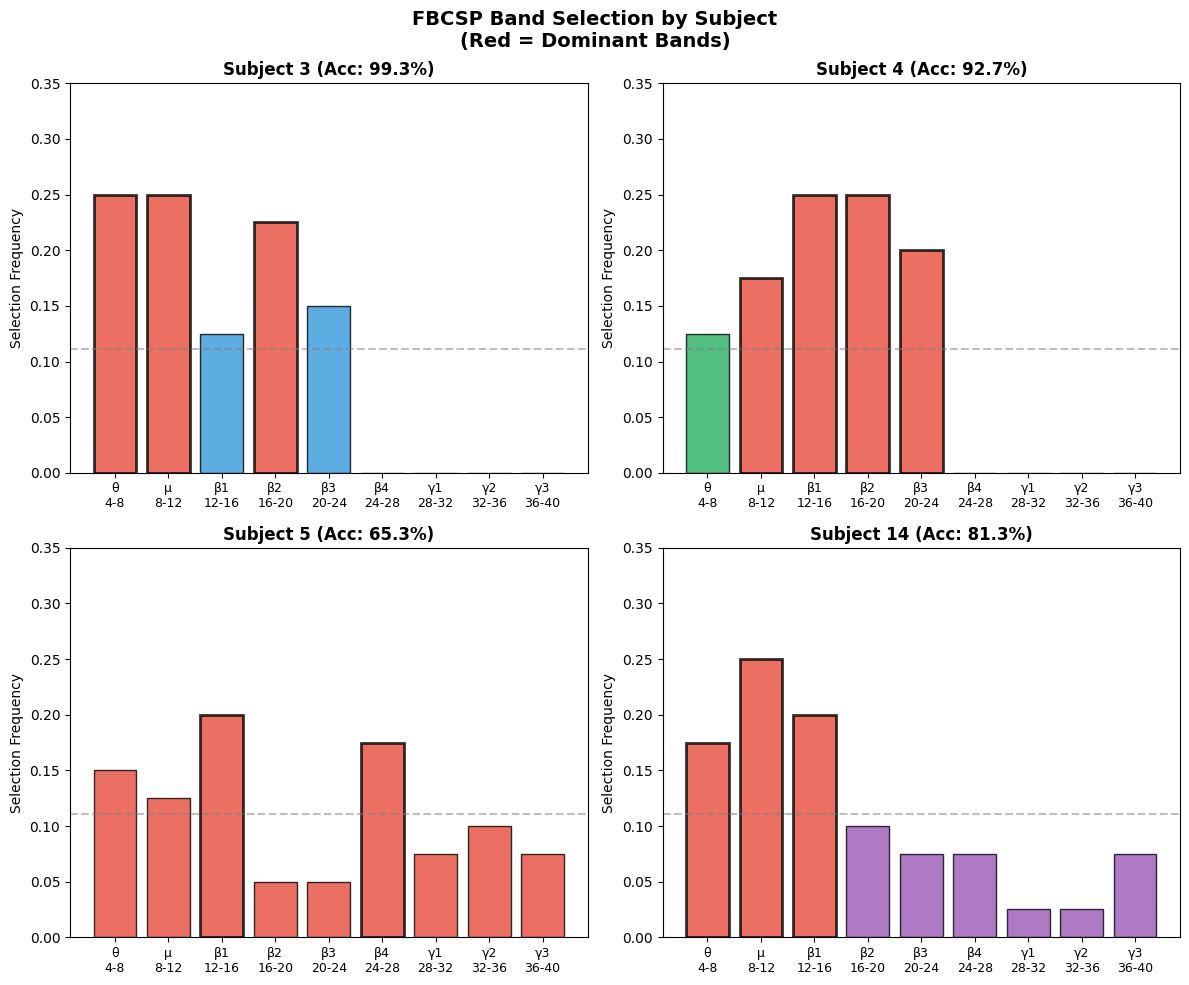

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Band names
band_names = ['4-8', '8-12', '12-16', '16-20', '20-24', '24-28', '28-32', '32-36', '36-40']
band_labels = ['θ\n4-8', 'μ\n8-12', 'β1\n12-16', 'β2\n16-20', 'β3\n20-24', 
               'β4\n24-28', 'γ1\n28-32', 'γ2\n32-36', 'γ3\n36-40']

# Extract band usage from your results (movement phase)
subjects = list(all_results.keys())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = ['#3498db', '#27ae60', '#e74c3c', '#9b59b6']

for idx, subj in enumerate(subjects):
    ax = axes[idx]
    
    if 'movement' in all_results[subj]:
        band_usage = all_results[subj]['movement']['band_usage']
        
        bars = ax.bar(range(9), band_usage, color=colors[idx], edgecolor='black', alpha=0.8)
        
        # Highlight dominant bands
        max_val = np.max(band_usage)
        for i, (bar, val) in enumerate(zip(bars, band_usage)):
            if val > 0.15:  # Highlight important bands
                bar.set_color('#e74c3c')
                bar.set_edgecolor('black')
                bar.set_linewidth(2)
        
        ax.set_xticks(range(9))
        ax.set_xticklabels(band_labels, fontsize=9)
        ax.set_ylabel('Selection Frequency')
        
        acc = all_results[subj]['movement']['accuracy']
        ax.set_title(f"{subj.replace('subject_', 'Subject ')} (Acc: {acc*100:.1f}%)", 
                    fontsize=12, fontweight='bold')
        ax.set_ylim(0, 0.35)
        ax.axhline(1/9, color='gray', linestyle='--', alpha=0.5, label='Uniform')

plt.suptitle('FBCSP Band Selection by Subject\n(Red = Dominant Bands)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_band_selection.png', dpi=300, bbox_inches='tight')
plt.show()

Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 9 dim * 1.3e+15  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1 (2.2e-16 eps * 9 dim * 5e+14  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.58 (2.2e-16 eps * 9 dim * 2.9e+14  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating

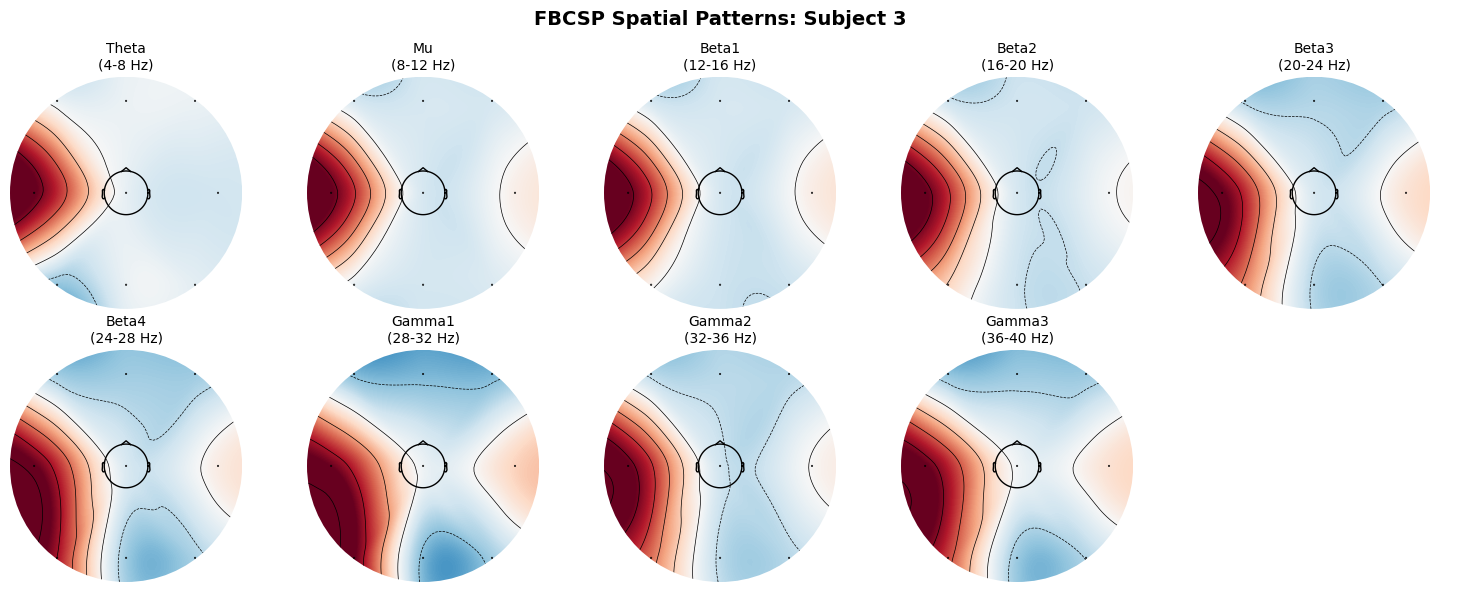

Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 9 dim * 5.5e+14  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.66 (2.2e-16 eps * 9 dim * 3.3e+14  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.4 (2.2e-16 eps * 9 dim * 2e+14  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimati

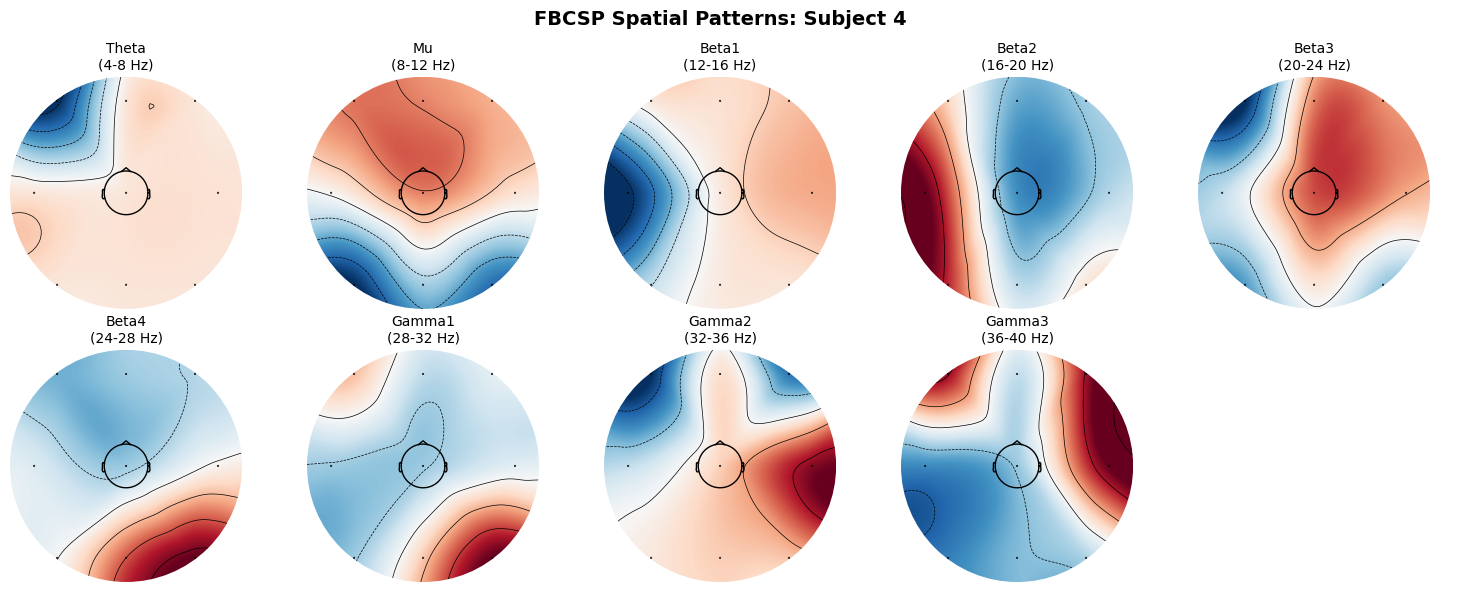

Computing rank from data with rank=None
    Using tolerance 0.098 (2.2e-16 eps * 9 dim * 4.9e+13  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.049 (2.2e-16 eps * 9 dim * 2.5e+13  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.038 (2.2e-16 eps * 9 dim * 1.9e+13  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
E

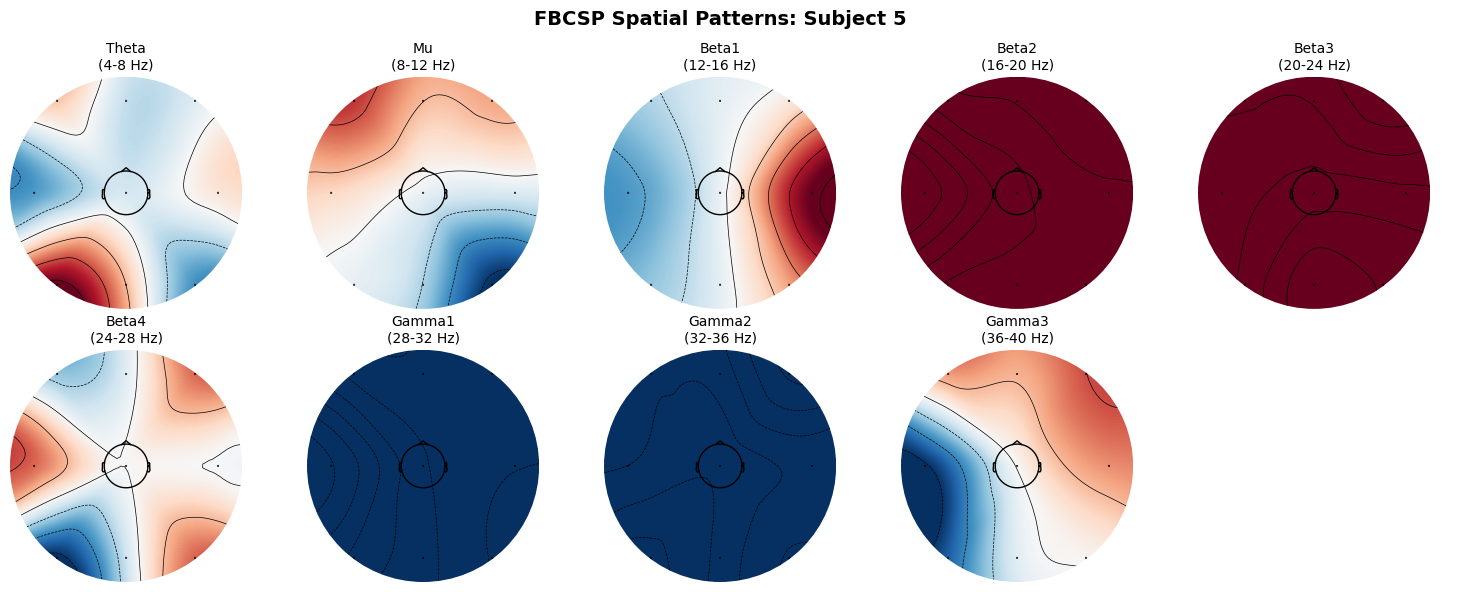

Computing rank from data with rank=None
    Using tolerance 6.2 (2.2e-16 eps * 9 dim * 3.1e+15  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.2 (2.2e-16 eps * 9 dim * 2.1e+15  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 9 dim * 1.3e+15  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimat

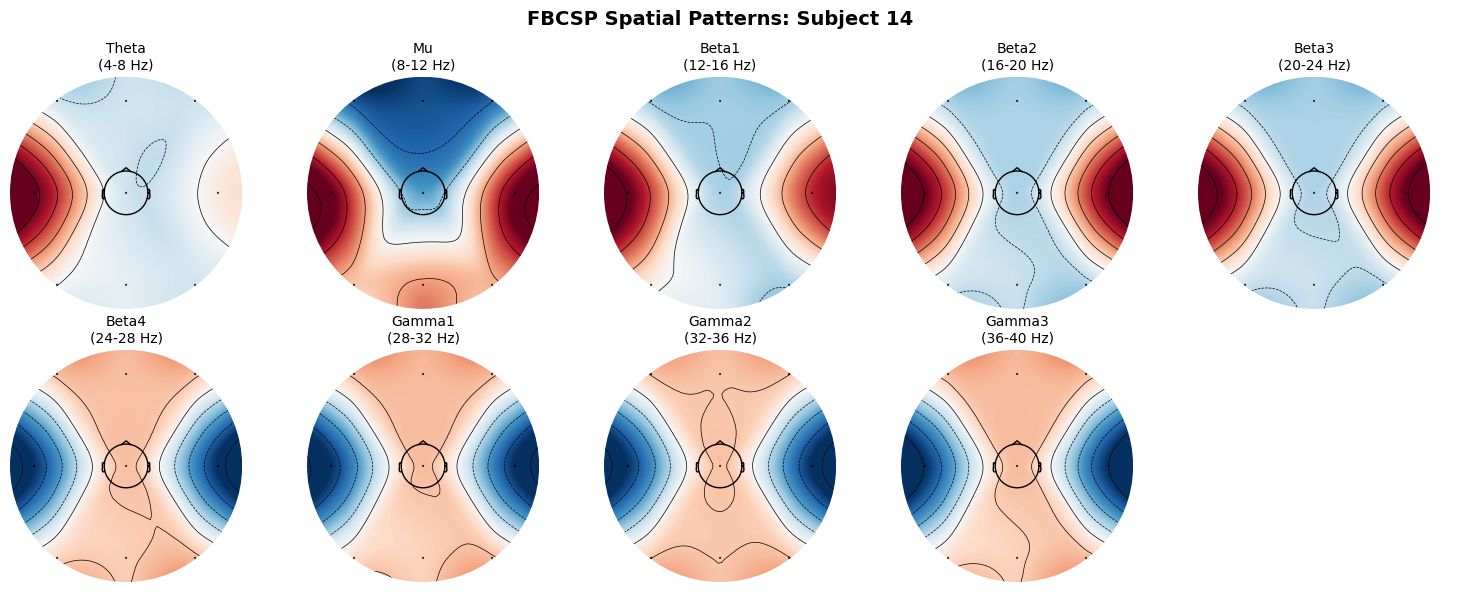

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from mne.viz import plot_topomap
from mne import create_info

# Channel positions for your 9 ROI channels (approximate 10-20 positions)
# These are normalized coordinates for plotting
channel_pos = {
    'F3': [-0.3, 0.4],
    'FZ': [0.0, 0.4],
    'F4': [0.3, 0.4],
    'C3': [-0.4, 0.0],
    'CZ': [0.0, 0.0],
    'C4': [0.4, 0.0],
    'P3': [-0.3, -0.4],
    'PZ': [0.0, -0.4],
    'P4': [0.3, -0.4]
}

pos = np.array([channel_pos[ch] for ch in ROI_CHANNELS])

def plot_fbcsp_topoplots(data, labels, subject_name, fs=256):
    """
    Plot CSP topoplots for each frequency band.
    """
    bands = [
        (4, 8, 'Theta'), (8, 12, 'Mu'), (12, 16, 'Beta1'), 
        (16, 20, 'Beta2'), (20, 24, 'Beta3'), (24, 28, 'Beta4'),
        (28, 32, 'Gamma1'), (32, 36, 'Gamma2'), (36, 40, 'Gamma3')
    ]
    
    # Select movement phase and ROI channels
    X = data[:, roi_indices, MOVEMENT_SLICE]
    y = labels
    
    # Apply CAR
    X = X - np.mean(X, axis=1, keepdims=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, (low, high, name) in enumerate(bands):
        ax = axes[i]
        
        # Bandpass filter
        from scipy import signal
        b, a = signal.butter(4, [low/(fs/2), high/(fs/2)], btype='band')
        X_filt = signal.filtfilt(b, a, X, axis=2)
        
        # Fit CSP
        csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)
        try:
            csp.fit(X_filt, y)
            
            # Get the most discriminative pattern (first or last component)
            pattern = csp.patterns_[0]  # First component
            
            # Plot topomap
            im, _ = plot_topomap(pattern, pos, axes=ax, show=False, cmap='RdBu_r')
            ax.set_title(f'{name}\n({low}-{high} Hz)', fontsize=10)
            
        except Exception as e:
            ax.text(0.5, 0.5, 'Failed', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{name}\n({low}-{high} Hz)', fontsize=10)
    
    # Hide last unused subplot
    axes[9].axis('off')
    
    plt.suptitle(f'FBCSP Spatial Patterns: {subject_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'fig_fbcsp_topo_{subject_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run for each subject
for subj in SUBJECT_LIST:
    folder_path = os.path.join(DATA_DIR, subj)
    data, labels, _ = load_subject_data(folder_path, ARTIFACT_THRESHOLD_UV)
    
    if data is not None:
        plot_fbcsp_topoplots(data, labels, subj.replace('subject_', 'Subject '))

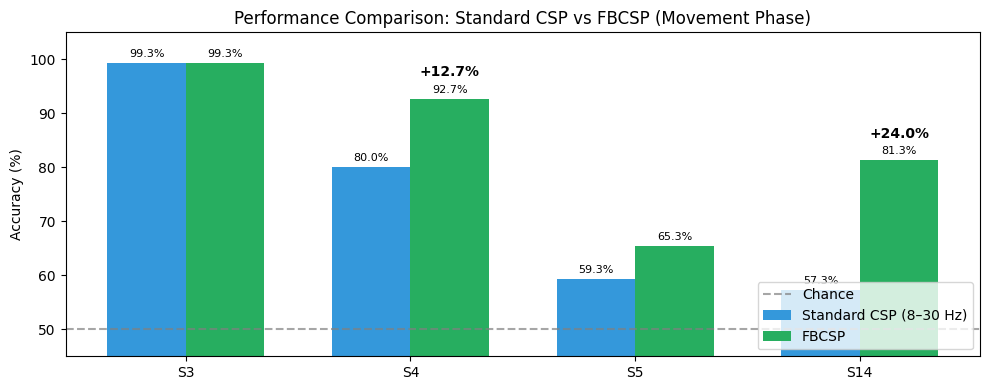


Figure saved: fig_fbcsp_comparison.png


In [18]:
# =============================================================================
# FIGURE: Standard CSP vs FBCSP (matched styling to your other plots)
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt

# ---- EXPECTED INPUTS ----
# 1) FBCSP results dict (you already have this as all_results in your FBCSP notebook)
fbcsp_results = all_results  # alias for clarity

# 2) Standard CSP baseline results dict (load/compute this in the same notebook, or paste it here)
#    Must have the same structure: results[subj]['movement']['accuracy']
#    Example name:
# csp_results = baseline_results
# If you don't have it as a dict, see the "fallback arrays" section below.


# ---- SUBJECTS (keep same ordering style) ----
subjects = list(fbcsp_results.keys())  # assumes both dicts share these keys

def to_percent(x):
    """Convert accuracy to percent if stored as 0-1."""
    x = float(x)
    return x * 100 if x <= 1.5 else x

acc_csp = np.array([99.3, 80.0, 59.3, 57.3]) 
acc_fbcsp = np.array([to_percent(fbcsp_results[s]['movement']['accuracy']) for s in subjects])
delta     = acc_fbcsp - acc_csp

# ---- STYLING (match your palette & annotation style) ----
fig, ax = plt.subplots(figsize=(10, 4))

x = np.arange(len(subjects))
width = 0.35

bars1 = ax.bar(x - width/2, acc_csp,   width, label='Standard CSP (8–30 Hz)', color='#3498db')
bars2 = ax.bar(x + width/2, acc_fbcsp, width, label='FBCSP',                 color='#27ae60')

ax.axhline(50, color='gray', linestyle='--', alpha=0.7, label='Chance')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Performance Comparison: Standard CSP vs FBCSP (Movement Phase)')
ax.set_xticks(x)
ax.set_xticklabels([s.replace('subject_', 'S') for s in subjects])
ax.set_ylim(45, 105)
ax.legend(loc='lower right')

# ---- VALUE LABELS (same style as your metrics plot) ----
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

# ---- IMPROVEMENT CALLOUTS for S4 and S14 (as in your caption) ----
for i, s in enumerate(subjects):
    s_label = s.replace('subject_', 'S')
    if s_label in ('S4', 'S14'):
        ax.annotate(f'+{delta[i]:.1f}%',
                    xy=(x[i] + width/2, acc_fbcsp[i]),
                    xytext=(0, 14),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('fig_fbcsp_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: fig_fbcsp_comparison.png")
